Directorio de ROIs: /home/diego/proyectos/betavae-xai-ad/data/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm
Archivo CSV de metadatos de sujetos: /home/diego/proyectos/betavae-xai-ad/data/SubjectsData.csv
Archivo de metadatos AAL3: /home/diego/proyectos/betavae-xai-ad/data/ROI_MNI_V7_vol.txt
Directorio de exportación: qc_outputs_doctoral
Columnas esperadas en .mat: 170
ROIs esperados tras limpieza AAL3: 166
Umbral de exclusión de ROIs pequeños (voxels): 100

--- Iniciando Bloque 0: Carga de Metadatos AAL3 ---
Metadatos AAL3 cargados: 166 entradas.
Se identificaron 166 ROIs válidos de AAL3 (después de excluir los 4 faltantes).
--- Bloque 0 Completado ---

--- Iniciando Bloque 1: Carga de Metadatos de Sujetos ---
Total de sujetos en CSV: 434
--- Bloque 1 Completado ---

--- Iniciando Bloque 3: QC Inicial por Sujeto ---

Conteo de sujetos por número de TimePoints:
TimePoints
140    155
197    230
200     49

=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===
                   c

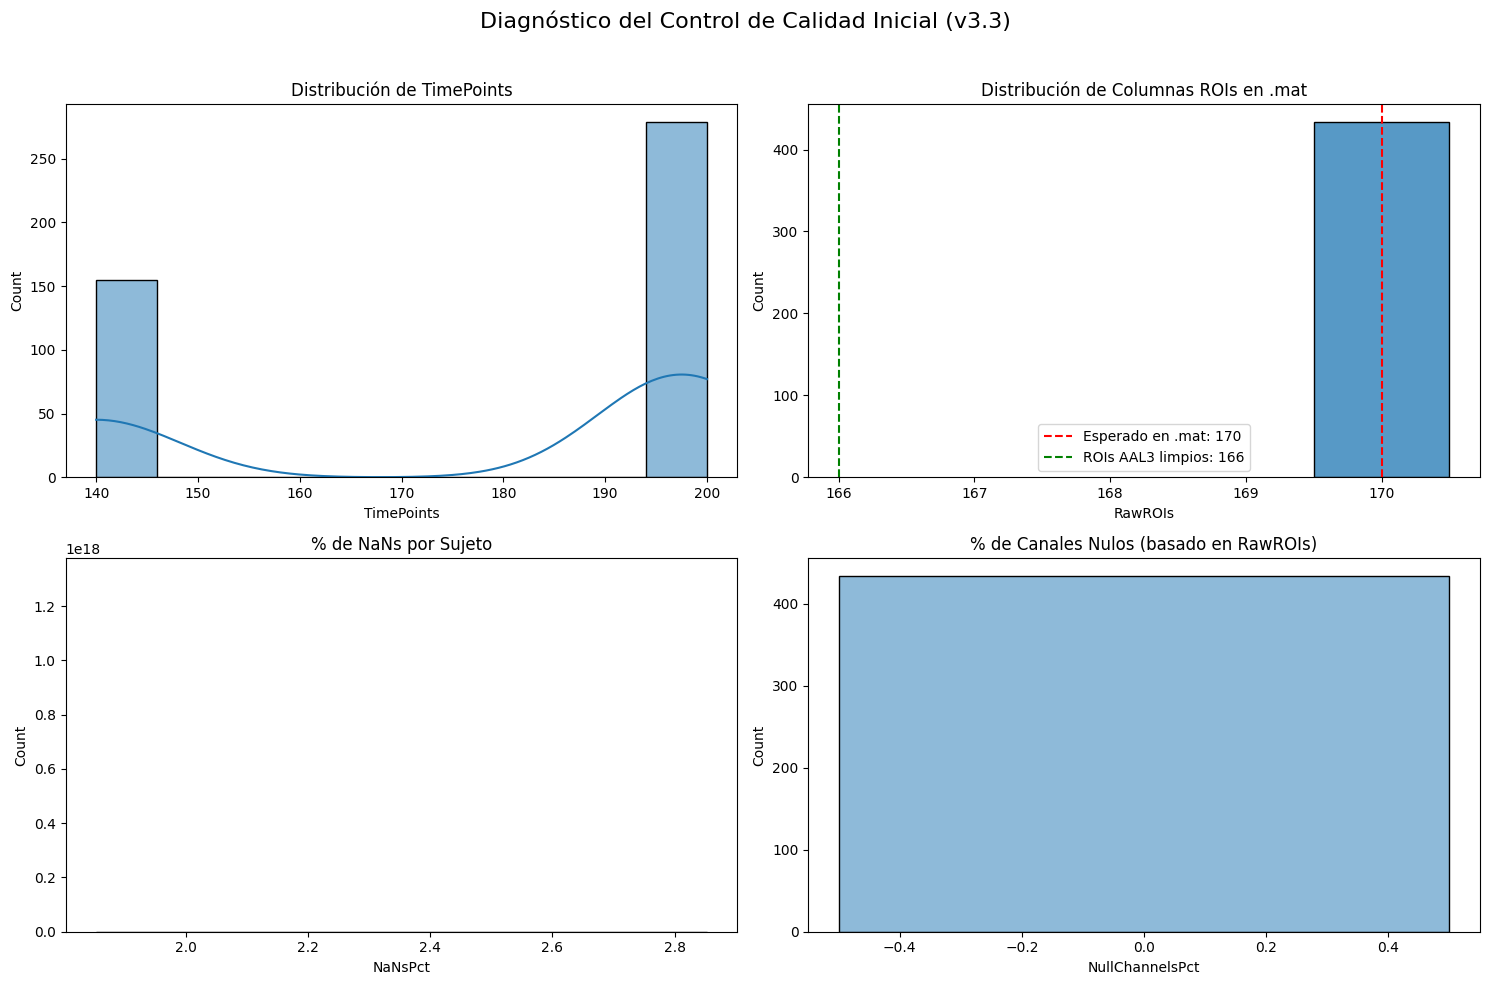

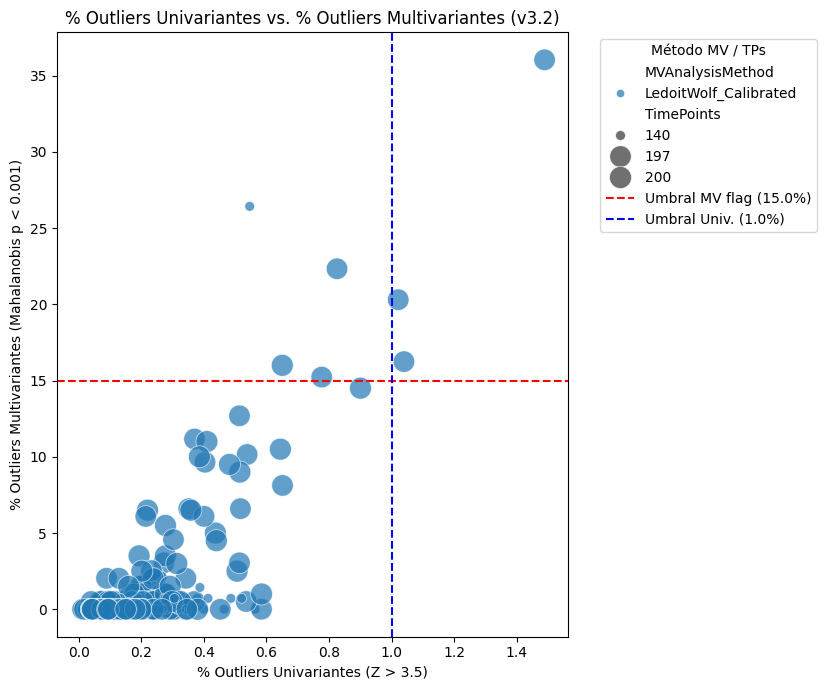

In [1]:
# ANÁLISIS DOCTORAL DE OUTLIERS EN SERIES BOLD en notebooks/qc_fmri_bold.ipynb


from __future__ import annotations
import os
from pathlib import Path
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, chi2, median_abs_deviation
from sklearn.covariance import MinCovDet, LedoitWolf
from sklearn.impute import SimpleImputer
import warnings
from numpy.linalg import LinAlgError # Importar LinAlgError para el manejo de excepciones
# Importar LinAlgWarning para el filtro de advertencias
try:
    from numpy.linalg import LinAlgWarning
except ImportError: # Para versiones más antiguas de NumPy donde podría no estar exportada directamente o no existir
    class LinAlgWarning(Warning): pass


# --- Ignorar UserWarnings (opcional) ---
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.covariance._robust_covariance')
# warnings.filterwarnings("ignore", category=RuntimeWarning) # Para nanvar de slices con NaNs, y otras advertencias de scipy/numpy

# ---------- CONFIGURACIÓN ----------
RUN_TAG = "v3.3"
ROI_DIR = Path('/home/diego/proyectos/betavae-xai-ad/data/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm') # Cambiar a la ruta correcta
#ROI_DIR = Path('/home/diego/Escritorio/AAL3/ROISignals_AAL3_NiftiPreprocessedAllBatchesNorm')
CSV_PATH = Path('/home/diego/proyectos/betavae-xai-ad/data/SubjectsData.csv')
AAL3_META_PATH = Path('/home/diego/proyectos/betavae-xai-ad/data/ROI_MNI_V7_vol.txt')

RAW_DATA_EXPECTED_COLUMNS = 170 # Columnas esperadas en .mat (AAL3 completo)
AAL3_MISSING_INDICES_1BASED = [35, 36, 81, 82] # Índices 'color' (1-based) de AAL3 que están vacíos/faltantes
EXPECTED_ROIS_AFTER_AAL3_CLEANUP = RAW_DATA_EXPECTED_COLUMNS - len(AAL3_MISSING_INDICES_1BASED) # Debería ser 166

SMALL_ROI_VOXEL_THRESHOLD = 100 # Umbral para excluir ROIs pequeños (vol_vox)

Z_THRESHOLD_UNIV = 3.5
# Para outliers univariantes, usar un umbral de porcentaje absoluto:
UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE = 1.0 # Ej: descartar si >5% de los puntos son outliers univariantes. AJUSTAR SEGÚN NECESIDAD.

ALPHA_MAHAL = 0.001 # p-valor para outliers multivariantes (usado en el cálculo de la distancia crítica)

MIN_TP_FOR_LEDOITWOLF = 50 # Mínimo TPs para intentar Ledoit-Wolf
MIN_TP_FOR_MCD_STRICT_FACTOR = 1.1 # Factor para MCD: TPs > ROIs_for_MV * factor
MIN_TIMEPOINTS_FOR_ANY_MV = 30 # Umbral absoluto mínimo de TPs para cualquier análisis MV (MCD o Ledoit)

EXPORT_DIR = Path('./qc_outputs_doctoral')

# --- Criterios de Exclusión (Ajustables) ---
TP_THRESHOLD_VALUE = 140 # Umbral ABSOLUTO de TPs para mantener un sujeto.
# Para outliers multivariantes (LW calibrado), este umbral *no* debería ser enorme.
# Con ALPHA_MAHAL=0.001, un orden de magnitud razonable suele estar ~0.1–2% (dependiendo de no-Gaussianidad).
MV_OUTLIER_PCT_FLAG_THRESHOLD = 15.0
MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_LEGACY = 17.5  # solo para comparación histórica (no recomendado como flag)
 
NANS_PCT_ABSOLUTE_THRESHOLD = 5.0
NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD = 1.0 # Para canales nulos en datos crudos (170 ROIs)
EXCLUDE_IF_MV_SKIPPED_INSUFFICIENT_DATA = True # ¿Excluir si análisis MV fue omitido por TPs <= ROIs_processed?

# Crear directorio de exportación
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Directorio de ROIs: {ROI_DIR}")
print(f"Archivo CSV de metadatos de sujetos: {CSV_PATH}")
print(f"Archivo de metadatos AAL3: {AAL3_META_PATH}")
print(f"Directorio de exportación: {EXPORT_DIR}")
print(f"Columnas esperadas en .mat: {RAW_DATA_EXPECTED_COLUMNS}")
print(f"ROIs esperados tras limpieza AAL3: {EXPECTED_ROIS_AFTER_AAL3_CLEANUP}")
print(f"Umbral de exclusión de ROIs pequeños (voxels): {SMALL_ROI_VOXEL_THRESHOLD}\n")

# ---------- 0. CARGA DE METADATOS AAL3 ----------
print("--- Iniciando Bloque 0: Carga de Metadatos AAL3 ---")
try:
    meta_aal3_df = pd.read_csv(AAL3_META_PATH, sep='\t')
    meta_aal3_df['color'] = pd.to_numeric(meta_aal3_df['color'], errors='coerce')
    meta_aal3_df.dropna(subset=['color'], inplace=True)
    meta_aal3_df['color'] = meta_aal3_df['color'].astype(int)
    
    print(f"Metadatos AAL3 cargados: {len(meta_aal3_df)} entradas.")
    required_aal3_cols = ['nom_c', 'color', 'vol_vox']
    if not all(col in meta_aal3_df.columns for col in required_aal3_cols):
        raise ValueError(f"El archivo de metadatos AAL3 debe contener las columnas: {required_aal3_cols}")
    
    valid_aal3_rois_info = meta_aal3_df[~meta_aal3_df['color'].isin(AAL3_MISSING_INDICES_1BASED)].copy()
    valid_aal3_rois_info.sort_values(by='color', inplace=True)
    valid_aal3_rois_info.reset_index(drop=True, inplace=True)

    if len(valid_aal3_rois_info) != EXPECTED_ROIS_AFTER_AAL3_CLEANUP:
        print(f"ADVERTENCIA: Se esperaban {EXPECTED_ROIS_AFTER_AAL3_CLEANUP} ROIs válidos tras filtrar los faltantes de AAL3, pero se encontraron {len(valid_aal3_rois_info)} en {AAL3_META_PATH}.")
    else:
        print(f"Se identificaron {len(valid_aal3_rois_info)} ROIs válidos de AAL3 (después de excluir los {len(AAL3_MISSING_INDICES_1BASED)} faltantes).")

except Exception as e:
    print(f"Error cargando metadatos AAL3 de {AAL3_META_PATH}: {e}")
    exit()
print("--- Bloque 0 Completado ---\n")

# ---------- FUNCIONES AUXILIARES DE UMBRAL (IQR/STD/MAD - no usadas directamente para UnivOutliersPct ahora) ----------
def iqr_threshold_upper(series: pd.Series, multiplier: float = 1.5) -> float:
    if series.empty or series.isna().all(): return np.nan
    q1, q3 = series.quantile([0.25, 0.75])
    if pd.isna(q1) or pd.isna(q3): return np.nan
    iqr = q3 - q1
    return q3 + multiplier * iqr

def std_threshold_upper(series: pd.Series, multiplier: float = 3.0) -> float:
    if series.empty or series.isna().all(): return np.nan
    mean_val, std_val = series.mean(), series.std()
    if pd.isna(mean_val) or pd.isna(std_val): return np.nan
    return mean_val + multiplier * std_val

def mad_threshold_upper(series: pd.Series, multiplier: float = 3.0) -> float:
    if series.empty or series.isna().all(): return np.nan
    median_val = series.median()
    mad_val_raw = (series.dropna() - median_val).abs().median()
    mad_val_scaled = mad_val_raw * 1.4826 
    if pd.isna(median_val) or pd.isna(mad_val_scaled) or mad_val_scaled == 0:
        print("Advertencia: MAD es 0, usando std para umbral univariante.")
        return std_threshold_upper(series, multiplier)
    return median_val + multiplier * mad_val_scaled

# ---------- 1. CARGA DE METADATOS DE SUJETOS Y RUTAS .mat ----------
print("--- Iniciando Bloque 1: Carga de Metadatos de Sujetos ---")
try:
    meta_df = pd.read_csv(CSV_PATH)
    SUBJECT_ID_COL = 'SubjectID' 
    meta_df[SUBJECT_ID_COL] = meta_df[SUBJECT_ID_COL].astype(str).str.strip()
    meta_df['MatPath'] = meta_df[SUBJECT_ID_COL].apply(lambda sid: ROI_DIR / f'ROISignals_{sid}.mat')
    meta_df['MatExists'] = meta_df['MatPath'].apply(lambda p: p.exists())
    subjects_with_mat = meta_df[meta_df['MatExists']].copy()
    # ... (resto de las verificaciones del CSV)
    if len(subjects_with_mat) == 0:
        raise FileNotFoundError("No se encontraron archivos .mat para ningún sujeto listado.")
    print(f"Total de sujetos en CSV: {len(meta_df)}")
    print("--- Bloque 1 Completado ---\n")
except Exception as e:
    print(f"Error en Bloque 1: {e}")
    exit()

# ---------- 2. FUNCIÓN DE QC INICIAL ----------
def qc_initial_subject(mat_path: Path, subject_id: str, raw_expected_cols: int):
    try:
        data = sio.loadmat(str(mat_path))
        signals_key = 'signals'
        if signals_key not in data:
            potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2 and v.shape[1] == raw_expected_cols]
            if not potential_keys:
                 potential_keys = [k for k, v in data.items() if isinstance(v, np.ndarray) and v.ndim == 2]
            if not potential_keys: raise KeyError(f"No se encontró '{signals_key}' u otra matriz 2D compatible en {mat_path.name}.")
            signals_key = potential_keys[0]
            print(f"Advertencia (Sujeto {subject_id}): Clave 'signals' no encontrada, usando '{signals_key}'.")
        signals_matrix = np.asarray(data[signals_key], dtype=float)
    except Exception as e:
        return {
            'Subject': subject_id, 'ErrorLoading': True, 'TimePoints': np.nan, 'RawROIs': np.nan,
            'RawROIsMatchExpected': False, 'NaNsCount': np.nan, 'NaNsPct': np.nan,
            'ZerosCount': np.nan, 'ZerosPct': np.nan, 'NullChannelsCount': np.nan,
            'NullChannelsPct': np.nan, 'SignalsMatrix': None, 'MatPath': mat_path.name,
            'ErrorMessage': str(e)[:100]
        }
    
    tp, raw_rois_count = signals_matrix.shape
    nan_count = np.isnan(signals_matrix).sum()
    nan_pct = 100 * nan_count / signals_matrix.size if signals_matrix.size > 0 else 0
    zero_count = np.sum(signals_matrix == 0)
    zero_pct = 100 * zero_count / signals_matrix.size if signals_matrix.size > 0 else 0
    null_channels_count = np.sum(np.all(signals_matrix == 0, axis=0)) if raw_rois_count > 0 else np.nan
    null_channels_pct = 100 * null_channels_count / raw_rois_count if raw_rois_count > 0 else np.nan
    
    return {
        'Subject': subject_id, 'MatPath': mat_path.name, 'ErrorLoading': False, 'ErrorMessage': None,
        'TimePoints': tp, 'RawROIs': raw_rois_count, 
        'RawROIsMatchExpected': raw_rois_count == raw_expected_cols,
        'NaNsCount': nan_count, 'NaNsPct': nan_pct,
        'ZerosCount': zero_count, 'ZerosPct': zero_pct, 'NullChannelsCount': null_channels_count,
        'NullChannelsPct': null_channels_pct, 'SignalsMatrix': signals_matrix
    }

# ---------- 3. LOOP DE QC INICIAL ----------
print("--- Iniciando Bloque 3: QC Inicial por Sujeto ---")
qc_initial_results = []
all_signals_matrices_raw = {}
for _, row in subjects_with_mat.iterrows():
    qc_result = qc_initial_subject(row['MatPath'], row[SUBJECT_ID_COL], RAW_DATA_EXPECTED_COLUMNS)
    qc_initial_results.append(qc_result)
    if qc_result['SignalsMatrix'] is not None:
        all_signals_matrices_raw[row[SUBJECT_ID_COL]] = qc_result['SignalsMatrix']

qc_initial_df = pd.DataFrame(qc_initial_results)
qc_display_df = qc_initial_df.drop(columns=['SignalsMatrix', 'ErrorMessage'], errors='ignore')
# --- Distribución exacta de TimePoints ---
tp_counts = qc_display_df['TimePoints'].value_counts().sort_index()
print("\nConteo de sujetos por número de TimePoints:")
print(tp_counts.to_string())

# Opcional: guardar CSV
tp_counts.to_csv(EXPORT_DIR / "tp_length_distribution.csv")

print("\n=== Estadísticas Descriptivas del QC Inicial (Raw Data) ===")
print(qc_display_df.rename(columns={'RawROIs': 'ROIs_in_MatFile', 
                                   'RawROIsMatchExpected': f'ROIs_in_MatFile_is_{RAW_DATA_EXPECTED_COLUMNS}'}).describe(include=np.number).T)
qc_display_df.to_csv(EXPORT_DIR / f'report_qc_initial_{RUN_TAG}.csv', index=False)
print(f"\nReporte de QC inicial guardado en: {EXPORT_DIR / f'report_qc_initial_{RUN_TAG}.csv'}")
 

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Diagnóstico del Control de Calidad Inicial ({RUN_TAG})', fontsize=16)
sns.histplot(qc_display_df['TimePoints'].dropna(), kde=True, ax=axes[0,0]).set_title('Distribución de TimePoints')
sns.histplot(qc_display_df['RawROIs'].dropna(), kde=False, discrete=True, ax=axes[0,1]).set_title('Distribución de Columnas ROIs en .mat')
axes[0,1].axvline(RAW_DATA_EXPECTED_COLUMNS, color='r', linestyle='--', label=f'Esperado en .mat: {RAW_DATA_EXPECTED_COLUMNS}')
axes[0,1].axvline(EXPECTED_ROIS_AFTER_AAL3_CLEANUP, color='g', linestyle='--', label=f'ROIs AAL3 limpios: {EXPECTED_ROIS_AFTER_AAL3_CLEANUP}')
axes[0,1].legend()
sns.histplot(qc_display_df['NaNsPct'].dropna(), kde=True, ax=axes[1,0]).set_title('% de NaNs por Sujeto')
sns.histplot(qc_display_df['NullChannelsPct'].dropna(), kde=True, ax=axes[1,1]).set_title('% de Canales Nulos (basado en RawROIs)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(EXPORT_DIR / f'plot_qc_initial_summary_{RUN_TAG}.png')
# plt.show() 

valid_subjects_df = qc_initial_df[~qc_initial_df['ErrorLoading'] & qc_initial_df['SignalsMatrix'].notna()].copy()
valid_subject_ids = valid_subjects_df['Subject'].tolist()
print(f"Número de sujetos válidos después del QC inicial: {len(valid_subject_ids)}")
print("--- Bloque 3 Completado ---\n")

# ---------- 4. DETECCIÓN DE OUTLIERS UNIVARIANTES ----------
print("--- Iniciando Bloque 4: Detección de Outliers Univariantes ---")
univariate_outlier_results = []
all_original_variances = {}
for subject_id in valid_subject_ids:
    signals_matrix = all_signals_matrices_raw[subject_id]
    if signals_matrix.size == 0:
        univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': np.nan, 'UnivOutliersPct': np.nan})
        all_original_variances[subject_id] = np.array([np.nan] * signals_matrix.shape[1])
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        original_variances = np.nanvar(signals_matrix, axis=0)
    all_original_variances[subject_id] = original_variances

    z_scores = zscore(signals_matrix, axis=0, nan_policy='omit')
    outlier_mask = np.abs(z_scores) > Z_THRESHOLD_UNIV
    univ_outliers_count = np.nansum(outlier_mask)
    num_valid_points = signals_matrix.size - np.sum(np.isnan(signals_matrix))
    univ_outliers_pct = 100 * univ_outliers_count / num_valid_points if num_valid_points > 0 else np.nan
    univariate_outlier_results.append({'Subject': subject_id, 'UnivOutliersCount': univ_outliers_count, 'UnivOutliersPct': univ_outliers_pct})

univariate_outliers_df = pd.DataFrame(univariate_outlier_results)
qc_processed_df = pd.merge(valid_subjects_df.drop(columns=['SignalsMatrix', 'ErrorMessage'], errors='ignore'), univariate_outliers_df, on='Subject', how='left')
qc_processed_df['MeanOriginalVariance'] = qc_processed_df['Subject'].apply(lambda sid: np.nanmean(all_original_variances.get(sid, np.nan)))
print("\n=== Estadísticas Descriptivas de Outliers Univariantes ===")
print(qc_processed_df[['UnivOutliersCount', 'UnivOutliersPct', 'MeanOriginalVariance']].describe().T)
print("--- Bloque 4 Completado ---\n")

# ---------- 5. PROCESAMIENTO DE ROIs Y DETECCIÓN DE OUTLIERS MULTIVARIANTES ----------
print("--- Iniciando Bloque 5: Procesamiento de ROIs y Outliers Multivariantes (Mejorado v3.3) ---")

multivariate_outlier_results = []
imputer = SimpleImputer(strategy='median')
aal3_missing_indices_0based = [idx - 1 for idx in AAL3_MISSING_INDICES_1BASED]

all_processed_signals_for_mv = {}

for subject_id in valid_subject_ids:
    signals_matrix_raw_170 = all_signals_matrices_raw[subject_id].copy()
    current_tp, current_raw_rois = signals_matrix_raw_170.shape
    roi_processing_log = []
    
    # --- 5.1 LIMPIEZA DE COLUMNAS (AAL3 y Small ROIs) ---
    if current_raw_rois != RAW_DATA_EXPECTED_COLUMNS:
        msg = f"Sujeto {subject_id}: Matriz cruda tiene {current_raw_rois} ROIs, se esperaban {RAW_DATA_EXPECTED_COLUMNS}. Omitiendo limpieza."
        roi_processing_log.append(msg)
        signals_matrix_after_aal3_cleanup = signals_matrix_raw_170.copy()
        rois_info_for_small_removal = pd.DataFrame()
    else:
        try:
            signals_matrix_after_aal3_cleanup = np.delete(signals_matrix_raw_170, aal3_missing_indices_0based, axis=1)
            msg = f"Eliminados {len(aal3_missing_indices_0based)} ROIs AAL3 faltantes/vacíos."
            roi_processing_log.append(msg)
            rois_info_for_small_removal = valid_aal3_rois_info.copy()
        except IndexError as e:
            msg = f"Error eliminando ROIs AAL3: {e}. Usando original."
            roi_processing_log.append(msg)
            signals_matrix_after_aal3_cleanup = signals_matrix_raw_170.copy()
            rois_info_for_small_removal = pd.DataFrame()
            
    # --- [NUEVO] CÁLCULO DE NANS ESTRUCTURALES VS REALES ---
    # Calculamos NaNs AHORA, sobre la matriz que ya no tiene los "huecos" conocidos del atlas.
    nans_count_cleaned = np.isnan(signals_matrix_after_aal3_cleanup).sum()
    nans_pct_cleaned = 100 * nans_count_cleaned / signals_matrix_after_aal3_cleanup.size if signals_matrix_after_aal3_cleanup.size > 0 else 0.0
    
    # --- 5.2 LIMPIEZA DE ROIs PEQUEÑOS ---
    signals_matrix_final_rois = signals_matrix_after_aal3_cleanup.copy()
    if not rois_info_for_small_removal.empty and rois_info_for_small_removal.shape[0] == signals_matrix_after_aal3_cleanup.shape[1]:
        small_rois_mask = rois_info_for_small_removal['vol_vox'] < SMALL_ROI_VOXEL_THRESHOLD
        indices_of_small_rois_to_drop = rois_info_for_small_removal[small_rois_mask].index.tolist()
        if indices_of_small_rois_to_drop:
            signals_matrix_final_rois = np.delete(signals_matrix_after_aal3_cleanup, indices_of_small_rois_to_drop, axis=1)
            msg = f"Eliminados {len(indices_of_small_rois_to_drop)} ROIs pequeños."
            roi_processing_log.append(msg)
    
    # --- 5.3 IMPUTACIÓN Y Z-SCORE ---
    if np.isnan(signals_matrix_final_rois).any():
        signals_matrix_imputed = imputer.fit_transform(signals_matrix_final_rois)
    else:
        signals_matrix_imputed = signals_matrix_final_rois.copy()

    if signals_matrix_imputed.size > 0:
        signals_matrix_zscored = zscore(signals_matrix_imputed, axis=0) 
    else:
        signals_matrix_zscored = signals_matrix_imputed.copy()
        
    all_processed_signals_for_mv[subject_id] = signals_matrix_zscored
    
    # --- 5.4 ANÁLISIS MULTIVARIANTE (Unificado Ledoit-Wolf + Calibración) ---
    n_samples, n_features = signals_matrix_zscored.shape
    mv_analysis_method = None
    mv_outliers_count = np.nan
    mv_outliers_pct = np.nan
    mv_skipped_reason = None
    md2_median = np.nan # Guardamos esto para el reporte global
    mv_scale_factor = np.nan
    mv_threshold_md2 = np.nan

    if n_features == 0:
        mv_skipped_reason = "No_ROIs_left"
        mv_analysis_method = "Skipped"
    elif n_samples < MIN_TIMEPOINTS_FOR_ANY_MV:
        mv_skipped_reason = f"Insufficient_TPs (<{MIN_TIMEPOINTS_FOR_ANY_MV})"
        mv_analysis_method = "Skipped"
    else:
        try:
            # Protección: si zscore dejó NaNs por std=0, evitamos romper LedoitWolf
            if np.isnan(signals_matrix_zscored).any() or np.isinf(signals_matrix_zscored).any():
                signals_matrix_zscored = np.nan_to_num(signals_matrix_zscored, nan=0.0, posinf=0.0, neginf=0.0)

            # 1. Estimación de Covarianza (Ledoit-Wolf funciona bien para N > D y N < D)
            lw = LedoitWolf().fit(signals_matrix_zscored)
            
            # 2. Cálculo de Distancias de Mahalanobis al Cuadrado (MD^2)
            diff = signals_matrix_zscored - lw.location_
            inv_cov = lw.precision_ # Usamos precision_ directamente (inversa de la covarianza)
            md2 = np.sum(np.dot(diff, inv_cov) * diff, axis=1)
            
            # 3. Calibración del Umbral (Escalado Empírico)
            # Calculamos la mediana de nuestras distancias
            current_md2_median = np.median(md2)
            
            # Calculamos cuál debería ser la mediana teórica de una Chi2 con df=n_features
            # (percentil 0.5 o mediana de la distribución chi2)
            theoretical_chi2_median = chi2.ppf(0.5, df=n_features)
            
            # Factor de escala: cuánto más "ancha" es nuestra distribución real vs la teórica
            # Si es NaN (caso raro), usamos 1.0
            scale_factor = 1.0
            if current_md2_median > 0 and not np.isnan(theoretical_chi2_median):
                scale_factor = current_md2_median / theoretical_chi2_median
            mv_scale_factor = scale_factor
            
            # 4. Definición del Umbral Crítico Calibrado
            # Tomamos el percentil teórico para ALPHA_MAHAL y lo multiplicamos por nuestro factor
            threshold_md2 = scale_factor * chi2.ppf(1 - ALPHA_MAHAL, df=n_features)
            mv_threshold_md2 = threshold_md2
            
            # 5. Detección de Outliers
            outlier_mask = md2 > threshold_md2
            mv_outliers_count = np.sum(outlier_mask)
            mv_outliers_pct = 100 * mv_outliers_count / n_samples
            md2_median = current_md2_median
            mv_analysis_method = "LedoitWolf_Calibrated"
            
            # Log opcional para ver qué está pasando (descomentar para debug)
            # print(f"  DEBUG ({subject_id}): Mediana MD2={current_md2_median:.2f}, Scale={scale_factor:.2f}, Thr={threshold_md2:.2f}, Outliers={mv_outliers_pct:.2f}%")
            
        except Exception as e:
            print(f"  ERROR LedoitWolf_Calibrated ({subject_id}): {e}")
            mv_skipped_reason = f"LW_Calib_Error: {str(e)[:50]}"
            mv_analysis_method = "LW_Calib_Failed"

    multivariate_outlier_results.append({
        'Subject': subject_id, 
        'MVOutliersCount': mv_outliers_count, 
        'MVOutliersPct': mv_outliers_pct,
        'MVAnalysisSkipped': mv_skipped_reason, 
        'MVAnalysisMethod': mv_analysis_method,
        'ROIs_for_MV': n_features,
        'MV_MD2_Median': md2_median, # <--- NUEVA MÉTRICA CLAVE
        'MV_ScaleFactor': mv_scale_factor,
        'MV_MD2_Threshold': mv_threshold_md2,
        'NaNsPct_Cleaned': nans_pct_cleaned, 
        'ROI_Processing_Log': " | ".join(roi_processing_log)
    })

# Generar DataFrame
multivariate_outliers_df = pd.DataFrame(multivariate_outlier_results)
qc_full_df = pd.merge(qc_processed_df, multivariate_outliers_df, on='Subject', how='left')

# ---------- 6. COMBINACIÓN DE MÉTRICAS Y VISUALIZACIONES ----------
print("--- Iniciando Bloque 6: Combinación de Métricas y Visualizaciones Globales ---")
numeric_cols_qc = [
    'UnivOutliersPct', 'MVOutliersPct',
    'NaNsPct', 'NaNsPct_Cleaned', 'ZerosPct', 'NullChannelsPct',
    'ROIs_for_MV', 'MeanOriginalVariance',
    'MV_MD2_Median', 'MV_ScaleFactor', 'MV_MD2_Threshold',
    'DVARS_mean', 'FD_mean', 'tSNR_mean', 'MRIQC_score']
for col in numeric_cols_qc:
    if col in qc_full_df.columns: qc_full_df[col] = pd.to_numeric(qc_full_df[col], errors='coerce')

print("\n=== Sanity check (MV calibrado) ===")
if 'MVOutliersPct' in qc_full_df.columns:
    print(qc_full_df['MVOutliersPct'].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_string())
if 'MV_ScaleFactor' in qc_full_df.columns:
    print("\nMV_ScaleFactor (mediana empírica / mediana chi2 teórica):")
    print(qc_full_df['MV_ScaleFactor'].describe(percentiles=[0.5, 0.9, 0.95, 0.99]).to_string())


plt.figure(figsize=(10, 7)) 
plot_data_scatter = qc_full_df[qc_full_df['MVOutliersPct'].notna() & qc_full_df['UnivOutliersPct'].notna()]

if not plot_data_scatter.empty:
    sns.scatterplot(x='UnivOutliersPct', y='MVOutliersPct', data=plot_data_scatter, alpha=0.7, 
                    hue='MVAnalysisMethod', 
                    size='TimePoints', 
                    sizes=(50, 250),
                    legend='auto') 
plt.title('% Outliers Univariantes vs. % Outliers Multivariantes (v3.2)')
plt.xlabel('% Outliers Univariantes (Z > 3.5)')
plt.ylabel('% Outliers Multivariantes (Mahalanobis p < 0.001)')
plt.axhline(MV_OUTLIER_PCT_FLAG_THRESHOLD, color='red', linestyle='--', label=f'Umbral MV flag ({MV_OUTLIER_PCT_FLAG_THRESHOLD}%)')
plt.axvline(UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE, color='blue', linestyle='--', label=f'Umbral Univ. ({UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE}%)')
plt.legend(title='Método MV / TPs', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1]) 
plt.savefig(EXPORT_DIR / 'plot_scatter_univ_vs_mv_outliers_v3.2.png'); 
# plt.show()

qc_full_df.to_csv(EXPORT_DIR / 'report_qc_full_compiled_v3.2.csv', index=False)
print(f"\nReporte completo guardado en: {EXPORT_DIR / 'report_qc_full_compiled_v3.2.csv'}")
print("--- Bloque 6 Completado ---\n")

# ---------- 7. DEFINICIÓN DE CRITERIOS DE EXCLUSIÓN (Refinado) ----------
print("--- Iniciando Bloque 7: Propuesta de Criterios de Exclusión (Refinado) ---")
thr_low_tp = TP_THRESHOLD_VALUE
thr_univ = UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE 
thr_mv = MV_OUTLIER_PCT_FLAG_THRESHOLD
thr_nans = NANS_PCT_ABSOLUTE_THRESHOLD
thr_null_channels_raw = NULL_CHANNELS_PCT_ABSOLUTE_THRESHOLD

qc_full_df['Discard_LowTP'] = qc_full_df['TimePoints'] < thr_low_tp
qc_full_df['Discard_HighUniv'] = qc_full_df['UnivOutliersPct'] > thr_univ
# qc_full_df['Discard_HighMV'] = qc_full_df['MVOutliersPct'] > thr_mv  <-- REMOVIDO COMO CRITERIO DURO
qc_full_df['Flag_HighMV'] = qc_full_df['MVOutliersPct'] > thr_mv
qc_full_df['Discard_HighNaNs'] = qc_full_df['NaNsPct_Cleaned'] > thr_nans
qc_full_df['Discard_HighNullRaw'] = qc_full_df['NullChannelsPct'] > thr_null_channels_raw
qc_full_df['Discard_RawROIsNotExpected'] = qc_full_df['RawROIs'] != RAW_DATA_EXPECTED_COLUMNS

if EXCLUDE_IF_MV_SKIPPED_INSUFFICIENT_DATA:
    qc_full_df['Discard_MV_InsufficientData'] = qc_full_df['MVAnalysisSkipped'].str.contains("Insufficient_TPs", na=False) | \
                                                qc_full_df['MVAnalysisSkipped'].str.contains("No_ROIs_left", na=False) 
else:
    qc_full_df['Discard_MV_InsufficientData'] = False

qc_full_df['Discard_MV_Error'] = qc_full_df['MVAnalysisMethod'].fillna("").str.contains("Failed", na=False) | qc_full_df['MVAnalysisSkipped'].fillna("").str.contains("Error", na=False)

critical_discard_conditions = [
    'Discard_LowTP', 'Discard_HighUniv', # 'Discard_HighMV'
    'Discard_HighNaNs', 'Discard_HighNullRaw', 
    'Discard_MV_InsufficientData', 'Discard_MV_Error'
]
existing_critical_conditions = [c for c in critical_discard_conditions if c in qc_full_df.columns]
qc_full_df['ToDiscard_Overall'] = qc_full_df[existing_critical_conditions].any(axis=1)

print("\n=== Umbrales de Exclusión Aplicados ===")
print(f"TimePoints < {thr_low_tp:.2f}")
print(f"% Outliers Univariantes (Absoluto) > {thr_univ:.3f}%")
print(f"% Outliers Multivariantes (FLAG, LW calibrado) > {thr_mv:.3f}%")
print(f"(Referencia histórica NO recomendada: {MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_LEGACY:.3f}%)")
print(f"% NaNs (Absoluto) > {thr_nans:.3f}%")
print(f"% Canales Nulos en datos crudos (Absoluto) > {thr_null_channels_raw:.3f}%")

print("\n=== Conteo de Sujetos por Criterio de Descarte Individual ===")
for col_name in existing_critical_conditions:
    if col_name in qc_full_df:
        print(f"Sujetos por '{col_name.replace('Discard_', '')}': {qc_full_df[col_name].sum()}")

subjects_to_discard_overall = qc_full_df[qc_full_df['ToDiscard_Overall']]
print(f"\nTotal de sujetos propuestos para descartar (combinado): {len(subjects_to_discard_overall)}")
print(f"Sujetos retenidos: {len(qc_full_df) - len(subjects_to_discard_overall)}")

qc_full_df.to_csv(EXPORT_DIR / f'report_qc_final_with_discard_flags_{RUN_TAG}.csv', index=False)
print(f"\nListas y reportes finales guardados en: {EXPORT_DIR}")
print("--- Bloque 7 Completado ---\n")

# ---------- 8. NOTAS PARA LA DISCUSIÓN DOCTORAL ----------
print("--- Bloque 8: Puntos Clave para la Discusión Doctoral (v3.2) ---")
num_initial_subjects = len(meta_df)
num_subjects_with_mat = len(subjects_with_mat)
num_valid_qc_initial = len(valid_subject_ids)
num_retained_final = len(qc_full_df) - len(subjects_to_discard_overall) if 'ToDiscard_Overall' in qc_full_df else len(qc_full_df)

print(f"1.  **Justificación de la Muestra Final:**")
print(f"    - Empezamos con {num_initial_subjects} sujetos en CSV, {num_subjects_with_mat} con .mat.")
print(f"    - {num_valid_qc_initial} procesados después de carga inicial.")
print(f"    - Se propuso descartar {len(subjects_to_discard_overall) if 'ToDiscard_Overall' in qc_full_df else 'N/A'}, resultando en una muestra final de {num_retained_final}.")
print(f"    - Discutir el impacto de `TP_THRESHOLD_VALUE = {TP_THRESHOLD_VALUE}`.")
print(f"    - Umbral univariante: `UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE = {UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE}%`.")
print(f"    - Umbral MV (flag, LW calibrado): `MV_OUTLIER_PCT_FLAG_THRESHOLD = {MV_OUTLIER_PCT_FLAG_THRESHOLD}%`.")
#print(f"    - Discutir umbrales absolutos: `UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE = {UNIV_OUTLIER_PCT_ABSOLUTE_THRESHOLD_VALUE}%` y `MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD = {MV_OUTLIER_PCT_ABSOLUTE_THRESHOLD}%`.")
print(f"    - Detallar el proceso de limpieza de ROIs AAL3 (4 faltantes + {SMALL_ROI_VOXEL_THRESHOLD} voxels) y su impacto en `ROIs_for_MV`.")
print(f"    - Impacto del uso de Ledoit-Wolf y el cálculo de %MV outliers para estos: ¿cuántos sujetos se 'rescataron' para análisis MV y cómo se comparan sus %MV outliers?")
num_lw = qc_full_df['MVAnalysisMethod'].eq('LedoitWolf_Calibrated').sum()
print(f"      - Sujetos analizados con LedoitWolf_Calibrated: {num_lw}")

mean_mv = qc_full_df.loc[qc_full_df['MVAnalysisMethod']=='LedoitWolf_Calibrated','MVOutliersPct'].mean()
print(f"      - Media %MV Outliers (LedoitWolf_Calibrated): {mean_mv:.3f}%" if pd.notna(mean_mv) else "      - Media %MV Outliers: N/A")

if 'MVOutliersPct' in qc_full_df.columns:
    pct_flag = (qc_full_df['MVOutliersPct'] > MV_OUTLIER_PCT_FLAG_THRESHOLD).mean() * 100
    print(f"      - % sujetos por encima del flag MV: {pct_flag:.2f}%")
print("\n2.  **Manejo de NaNs y Varianza:**")
print(f"    - NaNs estructurales esperados por AAL3: {100*len(AAL3_MISSING_INDICES_1BASED)/RAW_DATA_EXPECTED_COLUMNS:.3f}%")
print(f"    - NaNs reales post-limpieza (NaNsPct_Cleaned): {qc_full_df['NaNsPct_Cleaned'].mean():.3f}%")

print("\n3.  **Outliers Uni vs. Multi y Métricas Adicionales:**")
print(f"    - Comparar perfiles. Discutir el uso de umbrales absolutos y su justificación.")
print(f"    - (Si se implementan) Discutir el impacto de DVARS, FD, tSNR en la selección de sujetos.")

print("\n4.  **Estimación de Covarianza:**")
print(f"    - La introducción de Ledoit-Wolf permite el manejo de N < d. El cálculo de %MV outliers para estos sujetos permite un tratamiento más homogéneo.")
print(f"    - Discutir implicaciones para la estimación de conectividad funcional.")
print(f"    - Si persistieron advertencias de 'matriz singular', discutir colinealidad y cómo la pseudo-inversa ayuda.")
print("--- Fin del Análisis ---")

# Limpiar memoria (opcional)
if 'all_signals_matrices_raw' in locals(): del all_signals_matrices_raw
if 'all_processed_signals_for_mv' in locals(): del all_processed_signals_for_mv
if 'meta_aal3_df' in locals(): del meta_aal3_df


In [2]:
# --- Sensibilidad umbral univariante ---
thresholds = [0.5, 0.8, 1.0, 1.2, 1.5]
summary = []
for thr in thresholds:
    n_flag = (qc_full_df["UnivOutliersPct"] > thr).sum()
    summary.append((thr, int(n_flag)))

pd.DataFrame(summary, columns=["thr_univ_pct", "n_subjects_above_thr"]).sort_values("thr_univ_pct")


,thr_univ_pct,n_subjects_above_thr
0,0.5,21
1,0.8,5
2,1.0,3
3,1.2,1
4,1.5,0


In [3]:
ids_1_0 = set(qc_full_df.loc[qc_full_df["UnivOutliersPct"] > 1.0, "Subject"])
ids_1_2 = set(qc_full_df.loc[qc_full_df["UnivOutliersPct"] > 1.2, "Subject"])

print("Above 1.0%:", len(ids_1_0))
print("Above 1.2%:", len(ids_1_2))
print("Only in (1.0, 1.2]:", len(ids_1_0 - ids_1_2))
print(sorted(list(ids_1_0 - ids_1_2))[:20])


Above 1.0%: 3
Above 1.2%: 1
Only in (1.0, 1.2]: 2
['003_S_4354', '013_S_6768']


In [4]:
qc_full_df.loc[qc_full_df["UnivOutliersPct"] > 1.0, 
               ["Subject","UnivOutliersPct","MVOutliersPct","TimePoints","MeanOriginalVariance"]
              ].sort_values("UnivOutliersPct", ascending=False)


,Subject,UnivOutliersPct,MVOutliersPct,TimePoints,MeanOriginalVariance
201,035_S_7021,1.489206,36.040609,197,7943.247458
23,003_S_4354,1.039692,16.243655,197,2976.464635
100,013_S_6768,1.021344,20.304569,197,6617.358207


In [5]:
qc_full_df.loc[qc_full_df["MVOutliersPct"] > 15.0,
               ["Subject","MVOutliersPct","UnivOutliersPct","TimePoints","MeanOriginalVariance","MV_ScaleFactor"]
              ].sort_values("MVOutliersPct", ascending=False)


,Subject,MVOutliersPct,UnivOutliersPct,TimePoints,MeanOriginalVariance,MV_ScaleFactor
201,035_S_7021,36.040609,1.489206,197,7943.247458,0.192926
338,130_S_5231,26.428571,0.546472,140,40142.967181,0.299862
190,032_S_6855,22.335025,0.825638,197,3711.051593,0.332932
100,013_S_6768,20.304569,1.021344,197,6617.358207,0.358920
23,003_S_4354,16.243655,1.039692,197,2976.464635,0.363390
293,126_S_6683,16.000000,0.650602,200,3200.633764,0.380501
205,035_S_7120,15.228426,0.776711,197,839.986349,0.381860


In [6]:
thr_mv_99 = qc_full_df["MVOutliersPct"].quantile(0.99)
qc_full_df.loc[qc_full_df["MVOutliersPct"] >= thr_mv_99,
               ["Subject","MVOutliersPct","TimePoints","UnivOutliersPct","MeanOriginalVariance"]
              ].sort_values("MVOutliersPct", ascending=False)


,Subject,MVOutliersPct,TimePoints,UnivOutliersPct,MeanOriginalVariance
201,035_S_7021,36.040609,197,1.489206,7943.247458
338,130_S_5231,26.428571,140,0.546472,40142.967181
190,032_S_6855,22.335025,197,0.825638,3711.051593
100,013_S_6768,20.304569,197,1.021344,6617.358207
23,003_S_4354,16.243655,197,1.039692,2976.464635
